## Import Libraries

In [1]:
import uproot
import numpy as np
import numba
import matplotlib.pyplot as plt
import hist as hephist
from matplotlib.ticker import MaxNLocator,AutoMinorLocator # for minor ticks
from lmfit.models import PolynomialModel, GaussianModel # for the signal and background fits
from sklearn.gaussian_process import GaussianProcessRegressor 
import scipy.optimize
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ExpSineSquared, DotProduct, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.pipeline import Pipeline
import pandas as pd
import scipy.stats
from scipy import integrate as intg 
from scipy.integrate import trapz, simps, quad
import math
from uncertainties import ufloat
#%matplotlib inline
%matplotlib widget



## Open Root File and get Arrays of Branches from TTrees 

In [2]:
file = uproot.open("merged297runs_result.root")
#file=uproot.open("merged_flask_result.root")
#file=uproot.open("merged1634runs_all_target_result.root")

result_tree = file['result']
result_mix_tree = file['result_mix']
result_branches = result_tree.arrays()
result_mix_branches = result_mix_tree.arrays()

In [3]:
#print(result.keys())
#result_tree.show()
#result_branches = result_tree.arrays(library="pd") #to get as pandas data frame
#result_branches.head()

## Standard Cut(Mask) Values

In [4]:

mass_high = 10.
mass_low = 0.1

dim_z_low = 0.
dim_z_high = 500.

xF_low = -0.3
xF_high = 1.

costh_low = 0.5
costh_high = 0.5

dm_chisq_vtx_high = 17.
dm_chisq_vtx_low = 0.

#trk_chisq_upstream_high
trk_chisq_upstream_low =0#20.

#trk_chisq_target_high  
trk_chisq_target_low = 0#5.

trk_chisq_dump_high = 30
trk_chisq_dump_low = 0.

trk_vtx_z_diff = 270.

## Applying Cut(Mask) in Data

In [5]:
#Cuts for data
#--Z-vertex---
zvtx_mask_low = result_branches['dim_vtx_z'] > dim_z_low
zvtx_mask_high = result_branches['dim_vtx_z'] < dim_z_high
zvtx_mask = (zvtx_mask_low) & (zvtx_mask_high) 

#---mass---
mass_mask_low = result_branches['dim_mass'] > mass_low
mass_mask_high =result_branches['dim_mass'] < mass_high
mass_mask = (mass_mask_low) & (mass_mask_high)

#---xF---
xF_mask_low = result_branches['dim_xF'] > xF_low
xF_mask_high =result_branches['dim_xF'] < xF_high
xF_mask = (xF_mask_low) 

#---costh---
costh_mask = np.fabs(result_branches['dim_costh']) < costh_high

#---chisq----
chisq_dm_mask = result_branches['dim_chisq_vtx'] < dm_chisq_vtx_high

    ##--+ve track--
chisq_ptrkDump_mask_high =  result_branches['ptrk_chisq_dump'] < trk_chisq_dump_high
chisq_ptrkDump_mask_low =  result_branches['ptrk_chisq_dump'] > trk_chisq_dump_low
chisq_ptrkDump_mask = (chisq_ptrkDump_mask_low) & (chisq_ptrkDump_mask_high)

chisq_ptrkUpstream_mask = result_branches['ptrk_chisq_upstream'] > trk_chisq_upstream_low
chisq_ptrkTarget_mask = result_branches['ptrk_chisq_target'] > trk_chisq_target_low

chisq_prtk_mask = (chisq_ptrkDump_mask) & (chisq_ptrkTarget_mask) & (chisq_ptrkUpstream_mask) 

    ##-- -ve track--
chisq_ntrkDump_mask_high =  result_branches['ntrk_chisq_dump'] < trk_chisq_dump_high
chisq_ntrkDump_mask_low =  result_branches['ntrk_chisq_dump'] > trk_chisq_dump_low
chisq_ntrkDump_mask = (chisq_ntrkDump_mask_low) & (chisq_ntrkDump_mask_high)

chisq_ntrkUpstream_mask = result_branches['ntrk_chisq_upstream'] > trk_chisq_upstream_low
chisq_ntrkTarget_mask = result_branches['ntrk_chisq_target'] > trk_chisq_target_low

chisq_nrtk_mask = (chisq_ntrkDump_mask) & (chisq_ntrkTarget_mask) & (chisq_ntrkUpstream_mask) 

chisq_mask = (chisq_dm_mask) #& (chisq_prtk_mask) & (chisq_nrtk_mask)

#----rack sepearation
trk_seperation_mask = np.fabs(result_branches['ntrk_vtx_z'] - result_branches['ptrk_vtx_z'])<270.

#Net mask for data

data_mask = (mass_mask) & (zvtx_mask) & (trk_seperation_mask) & (chisq_mask) #& (xF_mask) & (costh_mask) 


## Applying Cut(Mask) in Mixed Data

In [6]:
#Cuts for mixed bkg
#--Z-vertex---
zvtx_mask_low = result_mix_branches['dim_vtx_z'] > dim_z_low
zvtx_mask_high = result_mix_branches['dim_vtx_z'] < dim_z_high
zvtx_mask = (zvtx_mask_low) & (zvtx_mask_high) 

#---mass---
mass_mask_low = result_mix_branches['dim_mass'] > mass_low
mass_mask_high =result_mix_branches['dim_mass'] < mass_high
mass_mask = (mass_mask_low) & (mass_mask_high)

#---xF---
xF_mask_low = result_mix_branches['dim_xF'] > xF_low
xF_mask_high =result_mix_branches['dim_xF'] < xF_high
xF_mask = (xF_mask_low) 

#---costh---
costh_mask = np.fabs(result_mix_branches['dim_costh']) < costh_high

#---chisq----
chisq_dm_mask = result_mix_branches['dim_chisq_vtx'] < dm_chisq_vtx_high

    ##--+ve track--
chisq_ptrkDump_mask_high =  result_mix_branches['ptrk_chisq_dump'] < trk_chisq_dump_high
chisq_ptrkDump_mask_low =  result_mix_branches['ptrk_chisq_dump'] > trk_chisq_dump_low
chisq_ptrkDump_mask = (chisq_ptrkDump_mask_low) & (chisq_ptrkDump_mask_high)

chisq_ptrkUpstream_mask = result_mix_branches['ptrk_chisq_upstream'] > trk_chisq_upstream_low
chisq_ptrkTarget_mask = result_mix_branches['ptrk_chisq_target'] > trk_chisq_target_low

chisq_prtk_mask = (chisq_ptrkDump_mask) & (chisq_ptrkTarget_mask) & (chisq_ptrkUpstream_mask) 

    ##-- -ve track--
chisq_ntrkDump_mask_high =  result_mix_branches['ntrk_chisq_dump'] < trk_chisq_dump_high
chisq_ntrkDump_mask_low =  result_mix_branches['ntrk_chisq_dump'] > trk_chisq_dump_low
chisq_ntrkDump_mask = (chisq_ntrkDump_mask_low) & (chisq_ntrkDump_mask_high)

chisq_ntrkUpstream_mask = result_mix_branches['ntrk_chisq_upstream'] > trk_chisq_upstream_low
chisq_ntrkTarget_mask = result_mix_branches['ntrk_chisq_target'] > trk_chisq_target_low

chisq_nrtk_mask = (chisq_ntrkDump_mask) & (chisq_ntrkTarget_mask) & (chisq_ntrkUpstream_mask) 

chisq_mask = (chisq_dm_mask) #& (chisq_prtk_mask) & (chisq_nrtk_mask)

#----track sepearation
trk_seperation_mask = np.fabs(result_mix_branches['ntrk_vtx_z'] - result_mix_branches['ptrk_vtx_z'])<270.


#Net mask for data
mix_mask = (mass_mask) & (zvtx_mask) & (trk_seperation_mask)  & (chisq_mask) & (xF_mask) & (costh_mask) 


## Getting Signal (Data - Mix) from Data and Mixed Distribution

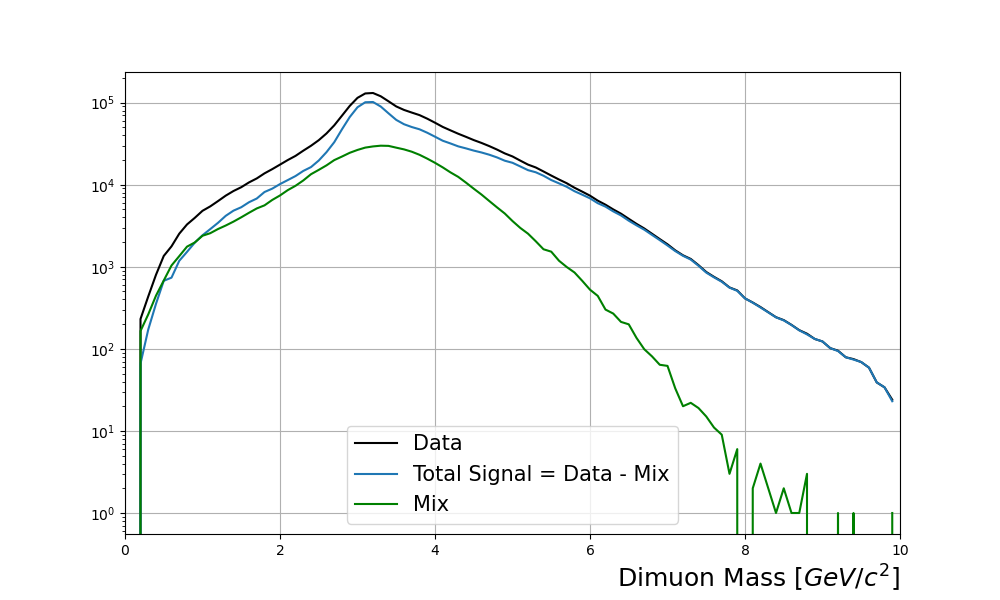

In [7]:
%matplotlib widget
data_mass=result_branches['dim_mass'][data_mask]
mix_mass=result_mix_branches['dim_mass'][mix_mask]
#data_mass=result_branches['dim_mass']
#mix_mass=result_mix_branches['dim_mass']

xmin = 0. # GeV
xmax = 10 # GeV
step_size = 0.1 # GeV
    
bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values
data_x,_ = np.histogram(data_mass, 
                           bins=bin_edges ) # histogram the data
data_x_errors = np.sqrt(data_x) # statistical error on the data

mix_x,_ = np.histogram(mix_mass, 
                           bins=bin_edges ) # histogram the data
mix_x_errors = np.sqrt(mix_x) # statistical error on the data

signal_x = data_x - mix_x

# data_x_mix_x = np.stack((data_x,mix_x), axis=1)
# cov_data_mix= np.cov(data_x_mix_x)
# sigma2_data_mix = np.sum(cov_data_mix, axis=0)

signal_x_errors = np.sqrt(np.square(data_x_errors)+np.square(mix_x_errors)) #- 2.*(np.sqrt(abs(sigma2_data_mix))) # statistical error on the data
#signal_x_errors = np.sqrt(abs(np.square(data_x_errors)+np.square(mix_x_errors) - 2.*(np.sqrt((sigma2_data_mix)))))
#print(np.square(data_x_errors)+np.square(mix_x_errors) - 2.*(np.sqrt(sigma2_data_mix)))

#signal_x_errors = np.sqrt((np.square(data_x_errors)+np.square(mix_x_errors) - 2.*(np.sqrt((sigma2_data_mix)))))
#print((signal_x_errors))
#signal_x_errors=np.sqrt(np.fabs(signal_x))

fig = plt.figure(figsize=(10,6))
plt.plot(bin_edges[0:-1], data_x,label="Data", color="black")
plt.plot(bin_edges[0:-1], signal_x,label="Total Signal = Data - Mix")
plt.plot(bin_edges[0:-1], mix_x,label="Mix",color="green")
#plt.errorbar(x=bin_centres, y = data_x, yerr=data_x_errors, fmt='ko')
#plt.yscale('log')
plt.xlabel('Dimuon Mass $[GeV/c^2]$',
                        x=1, horizontalalignment='right', 
                        fontsize=18 ) 
plt.grid(True)
plt.legend(loc='upper right')
plt.legend(prop={'size':15})
#plt.savefig("plot/all_mass_spectrum.png")
fig.savefig('plot/all_mass_spectrum.svg', format='svg', dpi=1200)
#plt.ion()
plt.xlim(right=10.) #xmax is your value
plt.xlim(left=.0) #xmin is your value
plt.yscale('log')
plt.show()


## Create Side Band for Training GPR

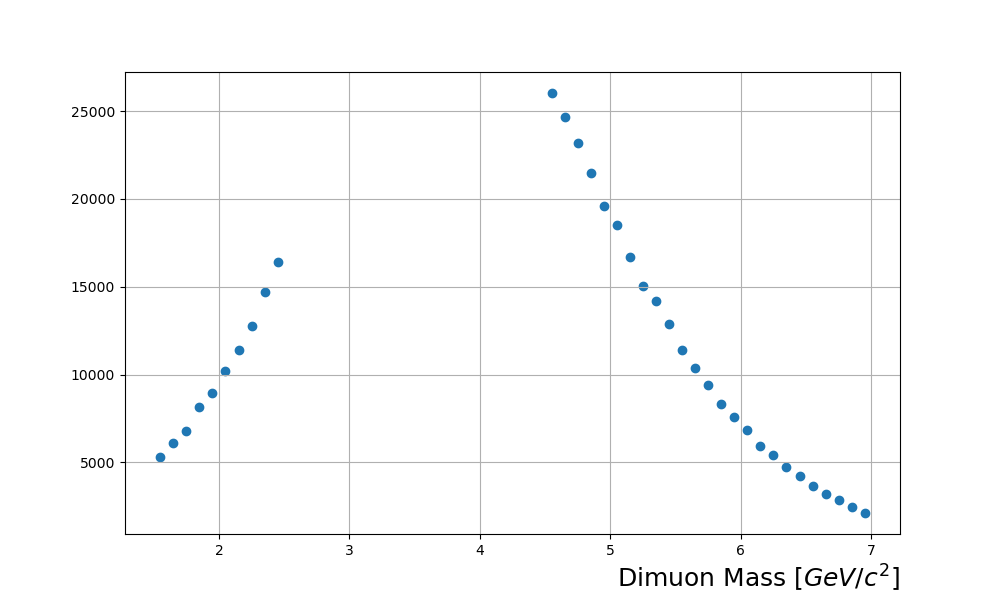

In [8]:
#create side band for traninng GPR
sideband = np.array([1.5, 2.5, 4.5, 7.0])
#sideband = np.array([0.5, 2.5, 4.8, 10.0])

data=np.column_stack((np.array(bin_centres),np.array(signal_x), np.array(signal_x_errors)))

mask = (((sideband[0] <= data[:,0]) & (data[:,0] <= sideband[1])) | ((sideband[2] <= data[:,0]) & (data[:,0] <= sideband[3])))
data_train = data[mask]
fig = plt.figure(figsize=(10,6))
train_axes = plt.gca()
X_train=data_train[:,0]
Y_train=data_train[:,1]
Y_train_error=data_train[:,2]
#print(len(X_train), len(Y_train))

train_axes.scatter(X_train,Y_train)
plt.xlabel('Dimuon Mass $[GeV/c^2]$',
                       x=1, horizontalalignment='right', fontsize=18 ) 



plt.grid(True)
plt.show()
#np.atleast_2d(X_train)
#print(np.count_nonzero(np.isnan(X_train)))
#print(np.count_nonzero(np.isnan(Y_train)))

## Select Kernel for GPR

In [9]:
#sideband_kernel = C(5000, (1e-10, 1e10))*RBF(1, (1e-20, 1e20))


sideband_kernel = C(5000.0, (1e-10, 1e15))*RBF(length_scale=5, length_scale_bounds=(1e-2, 1e15))
#10000 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e10)) #C(500, (1e-10, 1e10))*RBF(1, (1e-20, 1e20))
#gaussian_process = GaussianProcessRegressor(kernel=sideband_kernel, alpha=50000, n_restarts_optimizer=20)
gaussian_process = GaussianProcessRegressor(kernel=sideband_kernel, alpha=Y_train_error**2, n_restarts_optimizer=20)
gaussian_process.fit(np.atleast_2d(X_train).T, Y_train)
gaussian_process.kernel_


1.4e+04**2 * RBF(length_scale=1.45)

## Predict with GPR Kernel

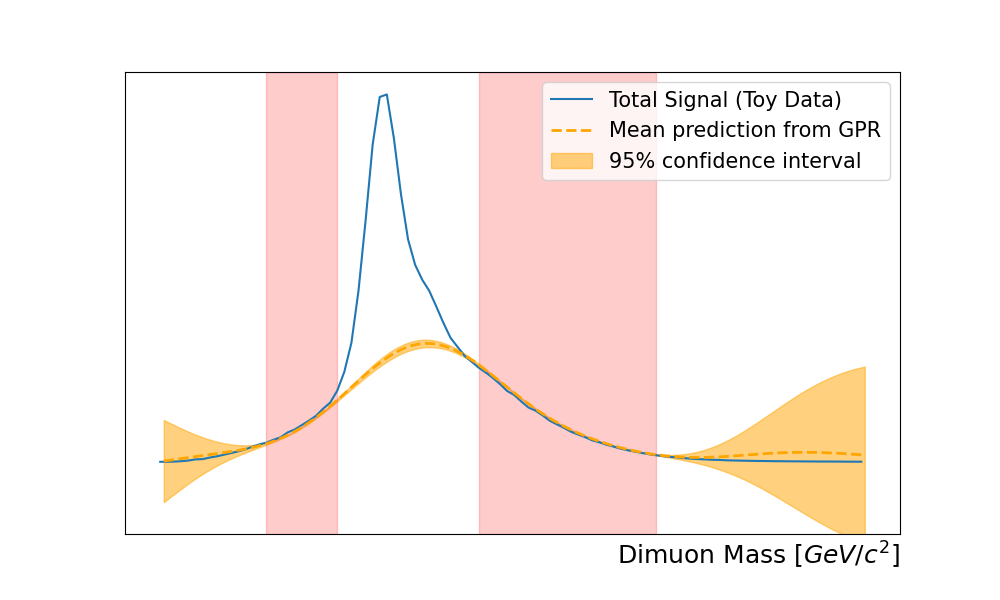

In [10]:

Y_pred, sigma = gaussian_process.predict(np.atleast_2d(data[:, 0]).T, return_std=True)
Y_pred, cov_matrix = gaussian_process.predict(np.atleast_2d(data[:, 0]).T, return_cov=True)

sigma2 = np.sum(cov_matrix, axis=0)
gpr_error = np.sqrt(abs(sigma2))
#gpr_error = sigma

fig = plt.figure(figsize=(10,6))
plt.plot(bin_edges[0:-1], signal_x,label="Total Signal (Toy Data)")
pred_axes = plt.gca()
pred_axes.plot(data[:,0],Y_pred, label="Mean prediction from GPR",color='orange',linestyle='--',linewidth=2)
pred_axes.fill_between(
    data[:,0].ravel(),
    Y_pred - 1.96 * sigma,
    Y_pred + 1.96 * sigma,
    alpha=0.5,
    label=r"95% confidence interval",
    color='orange'
)
plt.legend()
plt.legend(prop={'size':15})
plt.xticks(np.arange(xmin, xmax+1, 1.0))
plt.xlabel('Dimuon Mass $[GeV/c^2]$',
                        x=1, horizontalalignment='right', 
                        fontsize=18 ) 
plt.axvspan(1.5, 2.5, alpha=0.2, color='red')
plt.axvspan(4.5, 7., alpha=0.2, color='red')
plt.ylim(bottom=-20000.0)
plt.yticks([])#Turn off the Y-axis values
plt.xticks([])#Turn off the Y-axis values
plt.grid(True)
plt.show()

fig.savefig('plot/signal_band_gpr.png', format='png', dpi=800)

#fig = plt.figure(figsize=(14,8))
#plt.errorbar(x=bin_centres, y = Y_pred, yerr=data_x_errors, fmt='ko')
#plt.matshow(cov_matrix)
#plt.show()

In [11]:
peaks_signal=signal_x-Y_pred
peaks_signal_error = np.sqrt(np.square(signal_x_errors)+np.square(gpr_error))



# fig = plt.figure(figsize=(14,8))
# plt.plot(bin_edges[0:-1], peaks_signal,label="Peak Signals (Jpsi+Psi')",color='blue')
# plt.grid(True)
# plt.legend(prop={'size':20})
# plt.grid(True)
# plt.xlabel('Dimuon Mass $[GeV/c^2]$',
#                         x=1, horizontalalignment='right', 
#                         fontsize=18 ) 
#plt.show()
# fig.savefig('plot/peak_signals.svg', format='svg', dpi=1200)

## Fit the Peak Signals (Total Signal - GPR Prediction) with Double Gaussian

In [12]:
from lmfit.models import ExponentialModel, GaussianModel
from lmfit import Parameters, fit_report, minimize

# x=bin_centres[200:500]
# y=peaks_signal[200:500]
# y_err=peaks_signal_error[200:500]
x=bin_centres[20:50]
y=peaks_signal[20:50]
y_err=peaks_signal_error[20:50]


#print(y)
gauss1 = GaussianModel(prefix='g1_')
pars=(gauss1.make_params())

pars['g1_center'].set(value=3.17, min=1.4, max=4.0)
pars['g1_sigma'].set(value=0.24, min=0.1)
pars['g1_amplitude'].set(value=1000, min=10)
# pars['g1_center'].set(value=3.145)
# pars['g1_sigma'].set(value=0.245)
# pars['g1_amplitude'].set(value=100)



gauss2 = GaussianModel(prefix='g2_')
pars.update(gauss2.make_params())

pars['g2_center'].set(value=3.7, min=3., max=4.2)
pars['g2_sigma'].set(value=0.24, min=0.1)
pars['g2_amplitude'].set(value=100, min=0.1)   
# pars['g2_center'].set(value=3.731)
# pars['g2_sigma'].set(value=0.245)
# pars['g2_amplitude'].set(value=10)


# pars['g1_center'].vary = False
# pars['g1_sigma'].vary = False
# pars['g2_center'].vary = False
# pars['g2_sigma'].vary = False   

mod = gauss1 + gauss2  #exp_mod

def gaussian(x, amp, cen, wid):
    return amp/(wid*np.sqrt(math.pi*2)) * np.exp(-(x-cen)**2 / (2*wid**2))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 104
    # data points      = 30
    # variables        = 6
    chi-square         = 1.00057173
    reduced chi-square = 0.04169049
    Akaike info crit   = -90.0187744
    Bayesian info crit = -81.6115902
[[Variables]]
    g1_amplitude:  42219.0436 +/- 497.027683 (1.18%) (init = 1000)
    g1_center:     3.19038327 +/- 0.00327917 (0.10%) (init = 3.17)
    g1_sigma:      0.22908428 +/- 0.00207367 (0.91%) (init = 0.24)
    g1_fwhm:       0.53945225 +/- 0.00488311 (0.91%) == '2.3548200*g1_sigma'
    g1_height:     73522.9936 +/- 475.952677 (0.65%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_amplitude:  7672.62179 +/- 509.784971 (6.64%) (init = 100)
    g2_center:     3.78269364 +/- 0.01639683 (0.43%) (init = 3.7)
    g2_sigma:      0.21684088 +/- 0.01180047 (5.44%) (init = 0.24)
    g2_fwhm:       0.51062125 +/- 0.02778799 (5.44%) == '2.3548200*g2_sigma'
    g2_height:     14116.0345 +/- 509.264917 (3.

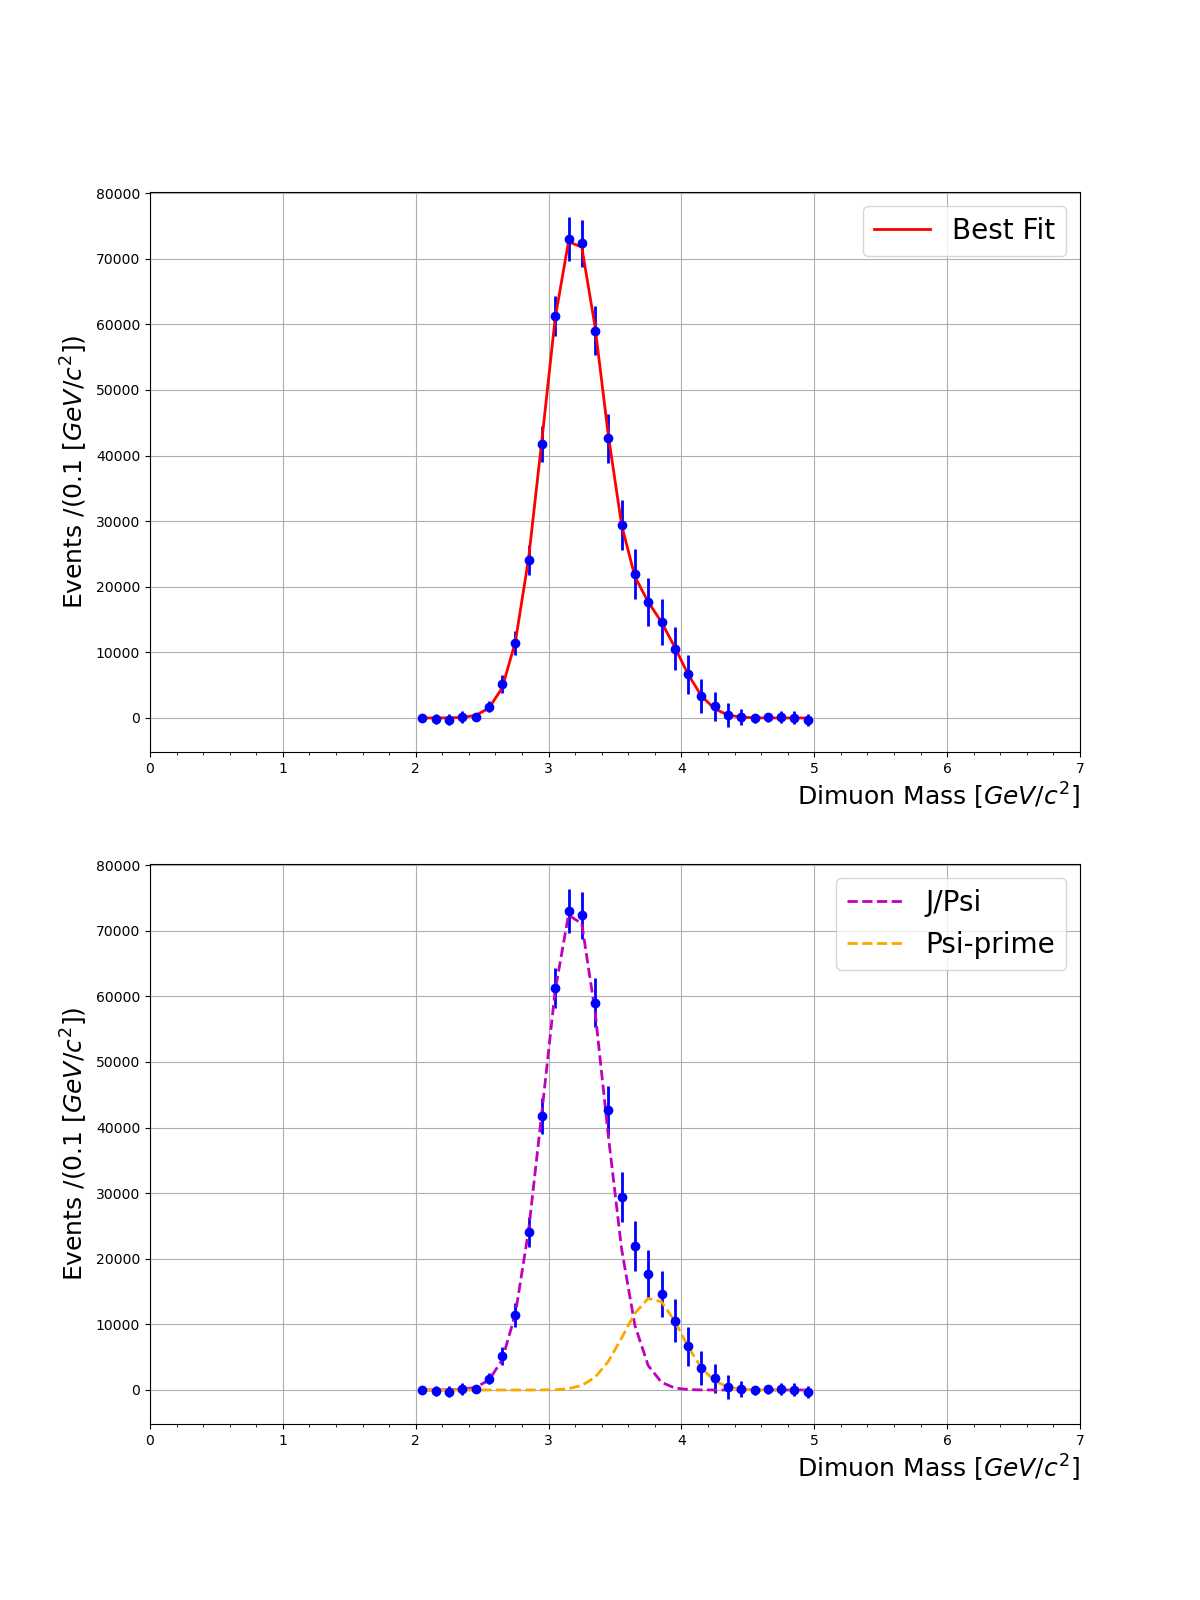

-----------------------------------
Parameter    Value       Stderr
g1_amplitude 42219.04360   497.02768
g1_center     3.19038     0.00328
g1_sigma     0.22908     0.00207
g1_fwhm     0.53945     0.00488
g1_height 73522.99360   475.95268
g2_amplitude  7672.62179   509.78497
g2_center     3.78269     0.01640
g2_sigma     0.21684     0.01180
g2_fwhm     0.51062     0.02779
g2_height 14116.03451   509.26492
-------------Integrals----------------------
42219.0426598137783003
7672.6219554220997452
Quad: Jpsi  (42219.07040777748, 7.074429279147962e-10)
Quad: PsiPrime  (7672.587664084629, 4.93969522187207e-10)


In [13]:
init = mod.eval(pars, x=x)
out = mod.fit(y, pars, x=x, weights=(1.0/(y_err)))
# Giving weights to Model.fit changes the array to minimize from (data-fit) to (data-fit)*weights

#print(out.fit_report(min_correl=0.5))
print(fit_report(out))

fig, axes = plt.subplots(2, 1, figsize=(12, 16))
#axes[0].errorbar(bin_centres,peaks_signal,yerr=peaks_signal_error,linewidth=2,color="blue",fmt='o')
axes[0].errorbar(x,y,yerr=y_err,linewidth=2,color="blue",fmt='o')
#axes[0].plot(x, init, '--', label='Initial Fit')
axes[0].plot(x, out.best_fit, '-', label='Best Fit',linewidth=2,color="red")
axes[0].legend()

comps = out.eval_components(x=x)
#axes[1].errorbar(bin_centres,peaks_signal,yerr=peaks_signal_error,linewidth=2,color="blue",fmt='o')
axes[1].errorbar(x,y,yerr=y_err,linewidth=2,color="blue",fmt='o')
#axes[1].errorbar(x,y,y_err, fmt="b.")
axes[1].plot(x, comps['g1_'], '--', label='J/Psi',linewidth=2,color="m")
#axes[1].plot(x, gaussian(x,42525.5786,3.18917410,0.22785154), '.', label='test',linewidth=2,color="black")
axes[1].plot(x, comps['g2_'], '--', label='Psi-prime',linewidth=2, color="orange")
axes[1].legend()

axes[0].grid(True)
axes[0].legend(loc='upper right')
axes[0].legend(prop={'size':20})
#axes[0].set_xticks(np.arange(xmin, xmax+1, 1.0))
axes[0].set_xticks(np.arange(0, 8, 1.0))
axes[0].xaxis.set_minor_locator( AutoMinorLocator() )
axes[0].set_xlabel('Dimuon Mass $[GeV/c^2]$',
                        x=1, horizontalalignment='right', 
                        fontsize=18 ) 

axes[0].set_ylabel('Events /(0.1 $[GeV/c^2])$',
                        fontsize=18 ) 


axes[1].grid(True)
axes[1].legend(loc='upper right')
axes[1].legend(prop={'size':20})
#axes[1].set_xticks(np.arange(xmin, xmax+1, 1.0))
axes[1].set_xticks(np.arange(0, 8, 1.0))
axes[1].xaxis.set_minor_locator( AutoMinorLocator() )


axes[1].set_ylabel('Events /(0.1 $[GeV/c^2])$',
                        fontsize=18 ) 
axes[1].set_xlabel('Dimuon Mass $[GeV/c^2]$',
                        x=1, horizontalalignment='right', 
                        fontsize=18 ) 

plt.show()
fig.savefig('plot/double_fit.svg', format='svg', dpi=1200)


print('-----------------------------------')
print('Parameter    Value       Stderr')
for name, param in out.params.items():
    print(f'{name:7s} {param.value:11.5f} {param.stderr:11.5f}')


#plt.errorbar(x,y,y_err, fmt="b.")
print('-------------Integrals----------------------')
print('{:18.16f}'.format(simps(comps['g1_'], x)))
print('{:18.16f}'.format(simps(comps['g2_'], x)))
print('Quad: Jpsi ',intg.quad(gaussian,2.,5.,args=(42219.0747,3.19038349,0.22908439),limit=1000))
print('Quad: PsiPrime ', intg.quad(gaussian,2.,5.,args=(7672.58774,3.78269482,0.21684009),limit=1000))
#print(intg.quad(gaussian,2.,5.,args=(42525.5779,3.18917410,0.22785154),limit=2000))
#print(intg.quad(gauss2,2.,5.,args=101285.762,limit=2000))

In [14]:
#def gaussian(x, amp, cen, wid):
#    return amp/(wid*np.sqrt(math.pi*2)) * np.exp(-(x-cen)**2 / (2*wid**2))
import uncertainties as u
@u.wrap
def guassian(amp, cen, wid):
    def integrand(x):
        return amp/(wid*np.sqrt(math.pi*2)) * np.exp(-(x-cen)**2 / (2*wid**2))
    integral, abserr = quad(integrand, 2.05, 4.95)
    return integral



g1_amplitude = u.ufloat(42219.07470, 497.07826)
g1_center  =u.ufloat(3.19038, 0.00328)
g1_sigma = u.ufloat(0.22908, 0.00207)
#print('Quad: Jpsi ',intg.quad(gaussian,2.,5.,args=(g1_amplitude,g1_center,g1_sigma),limit=1000)[0])
#square = g1_center**2
#print(square)
jpsi_yield = guassian(g1_amplitude,g1_center,g1_sigma)

g2_amplitude = u.ufloat(7672.58774, 509.83792)
g2_center  =u.ufloat(3.78269, 0.01640)
g2_sigma = u.ufloat(0.21684, 0.01180)
#print('Quad: Jpsi ',intg.quad(gaussian,2.,5.,args=(g1_amplitude,g1_center,g1_sigma),limit=1000)[0])
#square = g1_center**2
#print(square)
psip_yield = guassian(g2_amplitude,g2_center,g2_sigma)



print('{:18.4f}'.format(jpsi_yield))
print('{:18.4f}'.format(psip_yield))

        42219.0611+/-          497.0781
         7672.5875+/-          509.8379


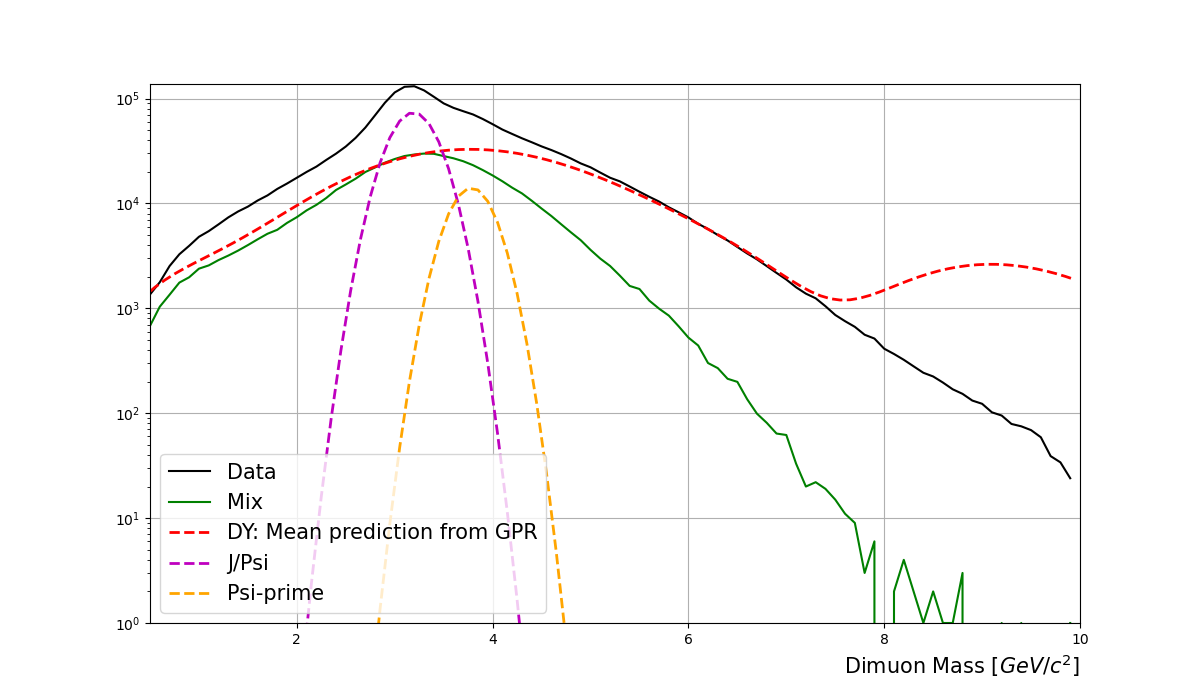

In [15]:
fig = plt.figure(figsize=(12,7))
plt.plot(bin_edges[0:-1], data_x,label="Data", color="black")
#plt.errorbar(bin_edges[0:-1], data_x, yerr= data_x_errors,label="Data", color="black",fmt='.')
plt.plot(bin_edges[0:-1], mix_x,label="Mix",color="green")
plt.plot(data[:,0],Y_pred, label="DY: Mean prediction from GPR",color='red',linestyle='--',linewidth=2)
plt.plot(x, comps['g1_'], '--', label='J/Psi',linewidth=2,color="m")
plt.plot(x, comps['g2_'], '--', label='Psi-prime',linewidth=2, color="orange")
plt.grid(True)
plt.legend(prop={'size':15})
plt.grid(True)
plt.xlabel('Dimuon Mass $[GeV/c^2]$',
                        x=1, horizontalalignment='right', 
                        fontsize=15 ) 
#plt.set_ylim(bottom=0)
#
plt.ylim(bottom=1)
plt.xlim(right=10.) #xmax is your value
plt.xlim(left=0.5) #xmin is your value
plt.yscale('log')
plt.show()


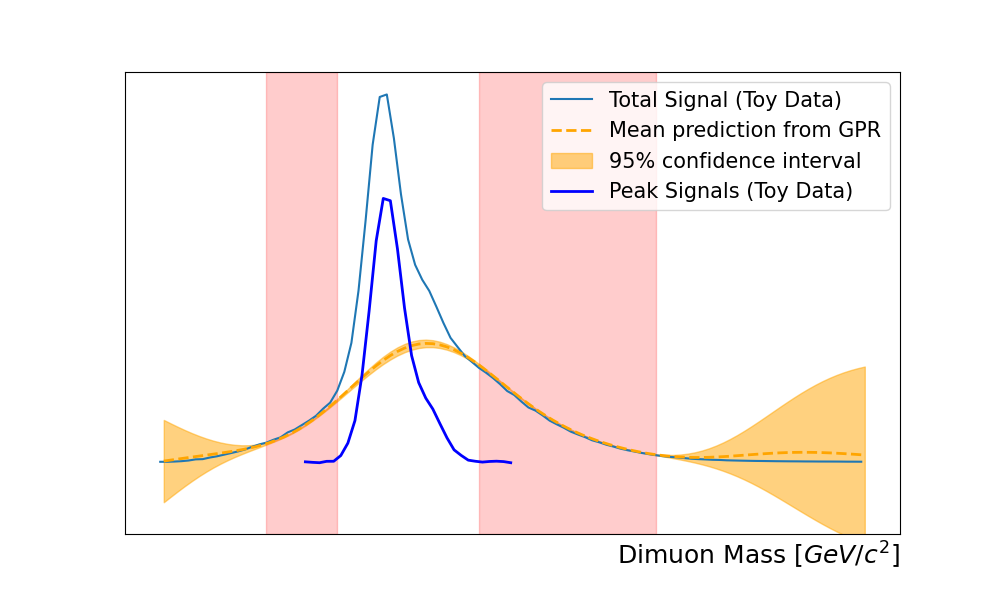

In [28]:
Y_pred, sigma = gaussian_process.predict(np.atleast_2d(data[:, 0]).T, return_std=True)
Y_pred, cov_matrix = gaussian_process.predict(np.atleast_2d(data[:, 0]).T, return_cov=True)

sigma2 = np.sum(cov_matrix, axis=0)
gpr_error = np.sqrt(abs(sigma2))
#gpr_error = sigma

fig = plt.figure(figsize=(10,6))
plt.plot(bin_edges[0:-1], signal_x,label="Total Signal (Toy Data)")
pred_axes = plt.gca()
pred_axes.plot(data[:,0],Y_pred, label="Mean prediction from GPR",color='orange',linestyle='--',linewidth=2)
pred_axes.fill_between(
    data[:,0].ravel(),
    Y_pred - 1.96 * sigma,
    Y_pred + 1.96 * sigma,
    alpha=0.5,
    label=r"95% confidence interval",
    color='orange'
)
plt.plot(x, y, '-', label='Peak Signals (Toy Data)',linewidth=2,color="blue")
# plt.plot(x, comps['g1_'], '--', label='J/Psi',linewidth=2,color="m")
# plt.plot(x, comps['g2_'], '--', label='Psi-prime',linewidth=2, color="orange")
plt.legend()
plt.legend(prop={'size':15})
plt.xticks(np.arange(xmin, xmax+1, 1.0))
plt.xlabel('Dimuon Mass $[GeV/c^2]$',
                        x=1, horizontalalignment='right', 
                        fontsize=18 ) 
plt.axvspan(1.5, 2.5, alpha=0.2, color='red')
plt.axvspan(4.5, 7., alpha=0.2, color='red')
plt.ylim(bottom=-20000.0)
plt.yticks([])#Turn off the Y-axis values
plt.xticks([])#Turn off the Y-axis values
plt.grid(True)
plt.show()

fig.savefig('plot/signal_band_gpr_peaks.png', format='png', dpi=800)

#fig = plt.figure(figsize=(14,8))
#plt.errorbar(x=bin_centres, y = Y_pred, yerr=data_x_errors, fmt='ko')
#plt.matshow(cov_matrix)
#plt.show()

## J/Psi and PsiPrime MonteCarlo Files 
Goal is to get PDF from GMC and use it to fit the peak signals

In [17]:
jpsi_file = uproot.open("mc_jpsi_dump_M026_S002_messy_all_0_mix1_pT_D.root")
jpsi_tree = jpsi_file['Tree']
jpsi_branches = jpsi_tree.arrays()

psiprime_file = uproot.open("mc_psiprime_dump_M026_S002_messy_all_0_mix1_pT_D.root")
psiprime_tree = psiprime_file['Tree']
psiprime_branches = psiprime_tree.arrays()
#jpsi_tree.show()

In [18]:
#--Z-vertex---
zvtx_mask_low_jpsi = jpsi_branches['Dmz'] > dim_z_low
zvtx_mask_high_jpsi = jpsi_branches['Dmz'] < dim_z_high
zvtx_mask_jpsi = (zvtx_mask_low_jpsi) & (zvtx_mask_high_jpsi) 

#---mass---
mass_mask_low_jpsi = jpsi_branches['mass'] > mass_low
mass_mask_high_jpsi =jpsi_branches['mass'] < mass_high
mass_mask_jpsi = (mass_mask_low_jpsi) & (mass_mask_high_jpsi)

#Dimoun chisq
dmchisq_mask_jpsi = jpsi_branches['Dmchisq'] < dm_chisq_vtx_high

#Trk Separation 

trk_seperation_mask_jpsi = np.fabs(jpsi_branches['Tnz0'] - jpsi_branches['Tpz0'])<270.

#Trigger matrix  MATRIX1
fpga1_jpsi = jpsi_branches['MATRIX1']>0

#TprdID
roadID_mask_jpsi = (jpsi_branches['TprdID']*jpsi_branches['TnrdID'])<0

jpsi_mask = (mass_mask_jpsi) & (zvtx_mask_jpsi) & (dmchisq_mask_jpsi) & (trk_seperation_mask_jpsi) & (fpga1_jpsi) & roadID_mask_jpsi & (roadID_mask_jpsi)


In [19]:
#--Z-vertex---
zvtx_mask_low_psip = psiprime_branches['Dmz'] > dim_z_low
zvtx_mask_high_psip = psiprime_branches['Dmz'] < dim_z_high
zvtx_mask_psip = (zvtx_mask_low_psip) & (zvtx_mask_high_psip) 

#---mass---
mass_mask_low_psip = psiprime_branches['mass'] > mass_low
mass_mask_high_psip = psiprime_branches['mass'] < mass_high
mass_mask_psip = (mass_mask_low_psip) & (mass_mask_high_psip)


#Dmchisq, TpChiDp,TnChiDp
dmchisq_mask_psip = psiprime_branches['Dmchisq'] < dm_chisq_vtx_high

#Tnz0,Tnz0

trk_seperation_mask_psip = np.fabs(psiprime_branches['Tnz0'] - psiprime_branches['Tpz0'])<270.

#Trigger matrix  MATRIX1
fpga1_psip = psiprime_branches['MATRIX1']>0
#TprdID
roadID_mask_psip = (psiprime_branches['TprdID']*psiprime_branches['TnrdID'])<0


psip_mask = (mass_mask_psip) & (zvtx_mask_psip) & (dmchisq_mask_psip) & (trk_seperation_mask_psip) & (fpga1_psip)&(roadID_mask_psip)



In [20]:
#jpsi_tree.show()
jpsi_mass=0.99*jpsi_branches['mass'][jpsi_mask]
psiprime_mass=0.99*psiprime_branches['mass'][psip_mask]
#jpsi_mass=jpsi_branches['mass']
#psiprime_mass=psiprime_branches['mass']




In [21]:
# #test = jpsi_branches['TprdID']*jpsi_branches['TnrdID'][roadID_mask_jpsi]
# print(len(jpsi_branches['TprdID']))
# print(len(jpsi_branches['TnrdID']))
# print(jpsi_branches['TprdID']*jpsi_branches['TnrdID'])
# #psiprime_mass = 0.5*psiprime_mass
# #print(psiprime_mass)
# print(len(jpsi_branches['TprdID'][roadID_mask_jpsi]))
# print(len(jpsi_branches['TnrdID'][roadID_mask_jpsi]))
# test = jpsi_branches['TprdID'][jpsi_mask]*jpsi_branches['TnrdID'][jpsi_mask]
# print(test)
#print(jpsi_mass)

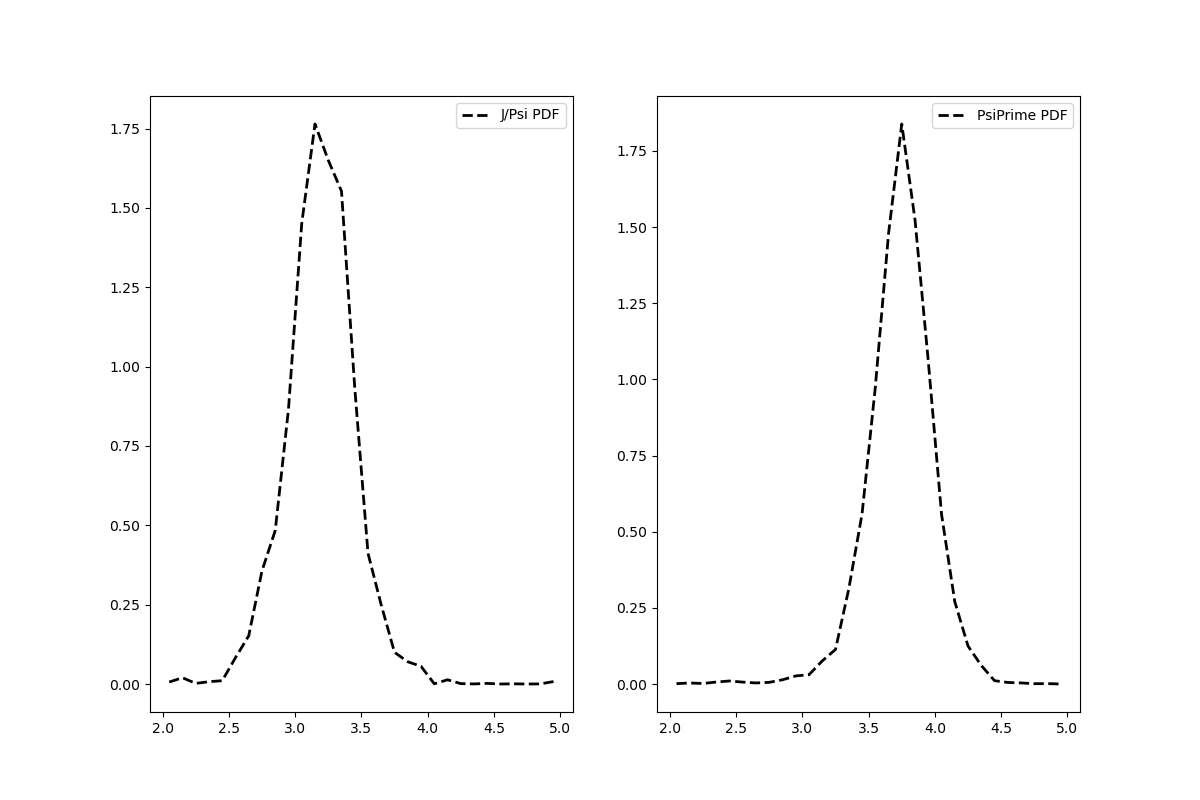

In [22]:
#making pdf for j/psi and psi'

jpsi_hist = np.histogram(jpsi_mass, weights=jpsi_branches['sigWeight'][jpsi_mask],
                            bins=100)
#jpsi_hist = np.histogram(jpsi_mass, weights=jpsi_branches['sigWeight'],
#                            bins=100)


jpsi_dist = scipy.stats.rv_histogram(jpsi_hist)

psiprime_hist = np.histogram(psiprime_mass, weights=psiprime_branches['sigWeight'][psip_mask],
                            bins=100) 
#psiprime_hist = np.histogram(psiprime_mass, weights=psiprime_branches['sigWeight'],
#                            bins=100) 

psiprime_dist = scipy.stats.rv_histogram(psiprime_hist)

#print(jpsi_hist[0].sum())

fig, axes1 = plt.subplots(1, 2, figsize=(12, 8))
axes1[0].plot(x, jpsi_dist.pdf(x), '--', label='J/Psi PDF',linewidth=2,color="black")
axes1[0].legend()
axes1[1].plot(x, psiprime_dist.pdf(x), '--', label='PsiPrime PDF',linewidth=2,color="black")
axes1[1].legend()
plt.show()
def jpsi_pdf(x, amp):
    #return (amp*jpsi_dist.pdf(x)/jpsi_hist[0].sum())
    return (amp*jpsi_dist.pdf(x))
def psiprime_pdf(x, amp):
    #return (amp*psiprime_dist.pdf(x)/psiprime_hist[0].sum())
    return (amp*psiprime_dist.pdf(x))       

In [23]:
from lmfit import Model


jpsi_model = Model(jpsi_pdf, prefix='jpsi_')
pars=(jpsi_model.make_params())
pars['jpsi_amp'].set(value=1000)


psip_model = Model(psiprime_pdf, prefix='psip_')
pars.update(psip_model.make_params())
pars['psip_amp'].set(value=100)   

model_peaks = jpsi_model + psip_model

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 30
    # variables        = 2
    chi-square         = 27.7807073
    reduced chi-square = 0.99216812
    Akaike info crit   = 1.69433244
    Bayesian info crit = 4.49672720
[[Variables]]
    jpsi_amp:  41316.3328 +/- 932.406742 (2.26%) (init = 1000)
    psip_amp:  8053.17415 +/- 1093.81078 (13.58%) (init = 100)
[[Correlations]] (unreported correlations are < 0.100)
    C(jpsi_amp, psip_amp) = -0.191


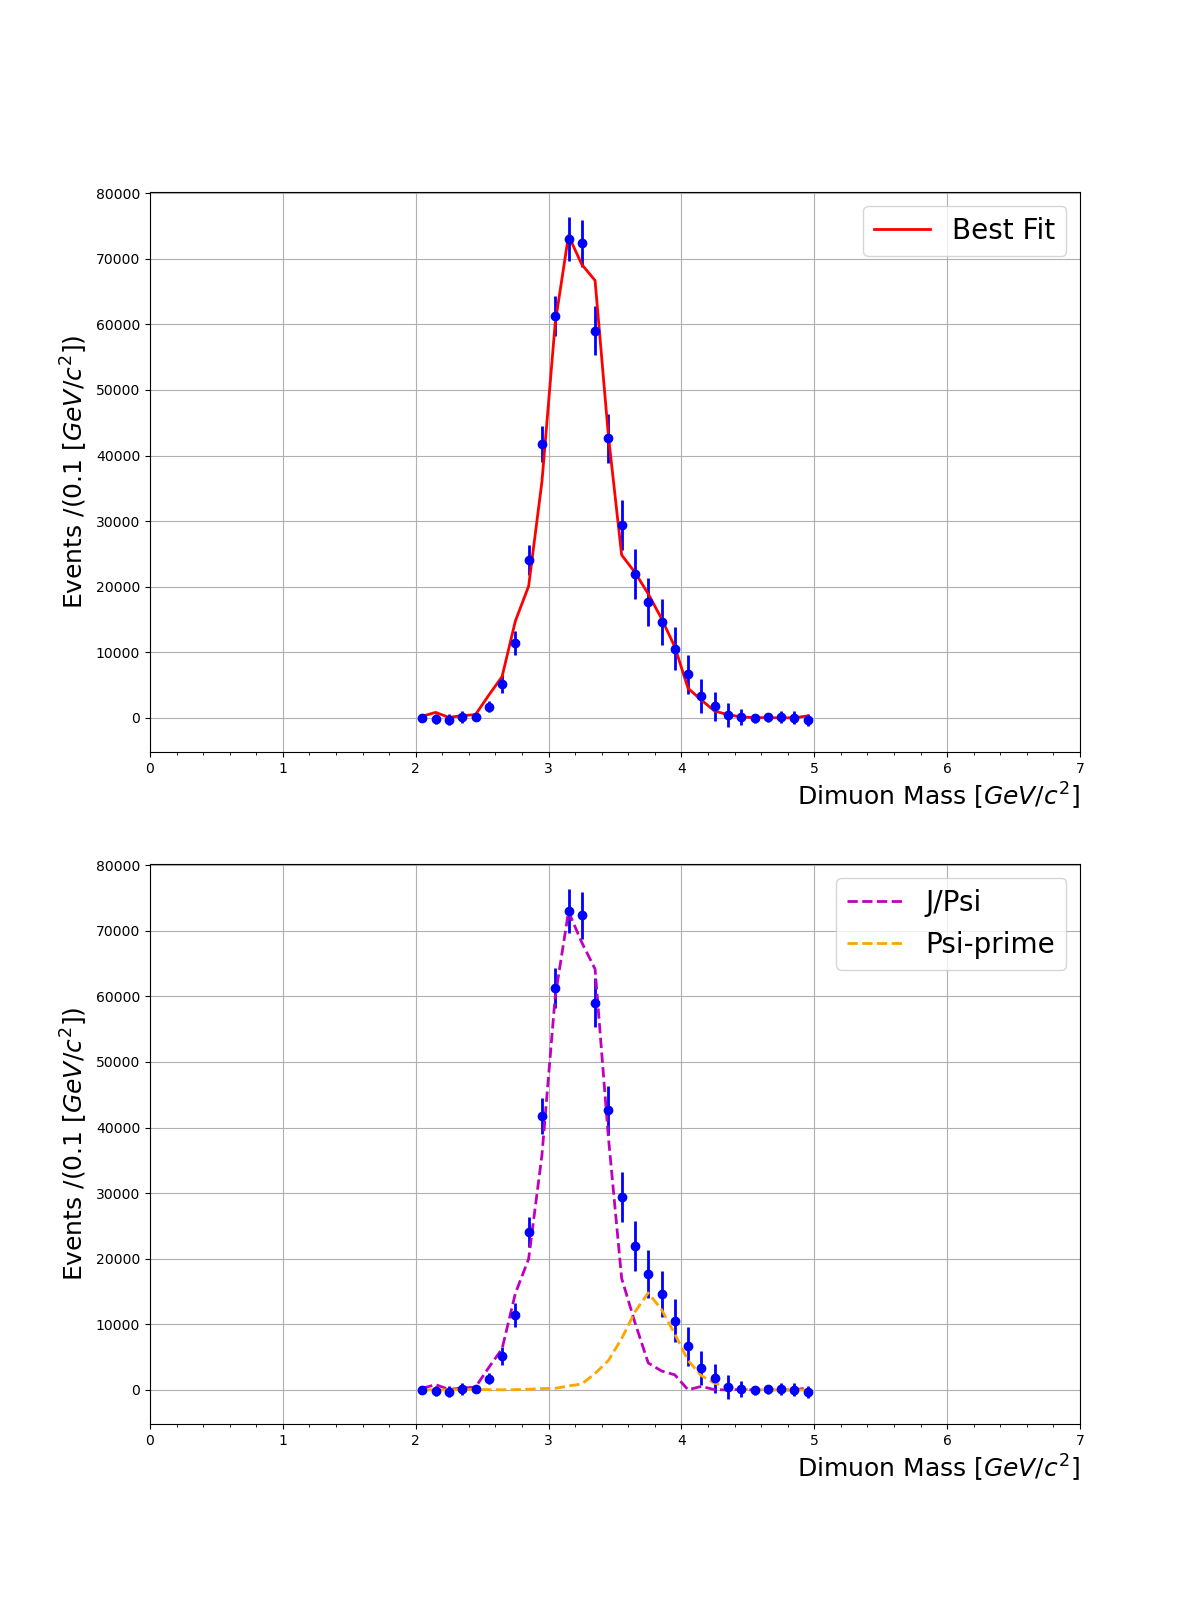

-------------------------------
Parameter    Value       Stderr
jpsi_amp 41316.33283   932.40674
psip_amp  8053.17415  1093.81078


In [24]:
y1=peaks_signal[20:50]
y1_err=peaks_signal_error[20:50]

# Giving weights to Model.fit changes the array to minimize from (data-fit) to (data-fit)*weights
result_peaks = model_peaks.fit(y1,pars,x=x, weights=(1.0/(y1_err)))

#print(result_peaks.fit_report())
print(fit_report(result_peaks))

fig, axes = plt.subplots(2, 1, figsize=(12, 16))
#axes[0].errorbar(bin_centres,peaks_signal,yerr=peaks_signal_error,linewidth=2,color="blue",fmt='o')
axes[0].errorbar(x,y,yerr=y_err,linewidth=2,color="blue",fmt='o')
#axes[0].plot(x, init, '--', label='Initial Fit')
axes[0].plot(x, result_peaks.best_fit, '-', label='Best Fit',linewidth=2,color="red")
axes[0].legend()

comps = result_peaks.eval_components(x=x)
#axes[1].errorbar(bin_centres,peaks_signal,yerr=peaks_signal_error,linewidth=2,color="blue",fmt='o')
axes[1].errorbar(x,y,yerr=y_err,linewidth=2,color="blue",fmt='o')
#axes[1].errorbar(x,y,y_err, fmt="b.")
axes[1].plot(x, comps['jpsi_'], '--', label='J/Psi',linewidth=2,color="m")
#axes[1].plot(x, psiprime_pdf(x,101285.762), '-', label='scaled Psi prime',linewidth=3,color="black")
#axes[1].plot(x, jpsi_pdf(x,484620.415), '--', label='scaled JPsi',linewidth=3,color="black")
axes[1].plot(x, comps['psip_'], '--', label='Psi-prime',linewidth=2, color="orange")
axes[1].legend()


axes[0].grid(True)
axes[0].legend(loc='upper right')
axes[0].legend(prop={'size':20})
#axes[0].set_xticks(np.arange(xmin, xmax+1, 1.0))
axes[0].set_xticks(np.arange(0, 8, 1.0))
axes[0].xaxis.set_minor_locator( AutoMinorLocator() )
axes[0].set_xlabel('Dimuon Mass $[GeV/c^2]$',
                        x=1, horizontalalignment='right', 
                        fontsize=18 ) 

axes[0].set_ylabel('Events /(0.1 $[GeV/c^2])$',
                        fontsize=18 ) 
# axes[0].set_ylim(bottom=1)
# axes[0].set_yscale('log')

axes[1].grid(True)
axes[1].legend(loc='upper right')
axes[1].legend(prop={'size':20})
#axes[1].set_xticks(np.arange(xmin, xmax+1, 1.0))
axes[1].set_xticks(np.arange(0, 8, 1.0))
axes[1].xaxis.set_minor_locator( AutoMinorLocator() )


axes[1].set_ylabel('Events /(0.1 $[GeV/c^2])$',
                        fontsize=18 ) 
axes[1].set_xlabel('Dimuon Mass $[GeV/c^2]$',
                        x=1, horizontalalignment='right', 
                        fontsize=18 ) 
# plt.ylim(bottom=1)
# plt.yscale('log')
plt.show()

print('-------------------------------')
print('Parameter    Value       Stderr')
for name, param in result_peaks.params.items():
    print(f'{name:7s} {param.value:11.5f} {param.stderr:11.5f}')

In [25]:
print('{:18.16f}'.format(simps(comps['jpsi_'], x)))
print('{:18.16f}'.format(simps(comps['psip_'], x)))
print('{:18.16f}'.format(simps(jpsi_dist.pdf(x), x)))

42333.5523161161981989
7311.3825508328909564
1.0246202752583491


In [26]:
# data_x_mix_x = np.stack((data_x,mix_x), axis=1)
# cov_data_mix= np.cov(data_x_mix_x)
# sigma2_data_mix = np.sum(cov_data_mix, axis=0)

In [27]:
amp_jpsi=u.ufloat(46692.01176, 1864.54525)

test_integrand =amp_jpsi*jpsi_dist.pdf(x)

#test_yield, error_yield= intg.quad(test_integral,2.05,4.95,limit=1000)
#print(intg.quad(psiprime_pdf,2.05,4.95,args=(9611.21055),limit=1000))

def func(amp_jpsi):
    def integrand(x):
        return amp_jpsi*jpsi_dist.pdf(x)
    integral, abserr = simps(integrand)
    #integral=amp_jpsi
    return integral

amp_jpsi=u.ufloat(46692.01176, 1864.54525)
#sol = func(amp_jpsi)
print('{:18.16f}'.format(sol))


NameError: name 'sol' is not defined